## **Instalación de paquetes y librerías**




In [2]:
# !pip install kplr
# !pip install lightkurve
# !pip install --upgrade tensorflow
# !pip show tensorflow
from numpy.random import seed
seed(10)
# from tensorflow import set_random_seed
import tensorflow
tensorflow.random.set_seed(10)

In [3]:
# Carga de librerias
# import kplr
import lightkurve as lc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sn
import sklearn

from astropy.io import fits
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
from keras.layers.merge import concatenate
from lightkurve import search_targetpixelfile
from lightkurve import search_lightcurvefile
from numpy import sqrt
from numpy import argmax
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score

In [4]:
# Code to read csv file into Colaboratory:!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## **Subida de fichero KOI descargado de la web**

In [6]:
from google.colab import files
uploaded = files.upload()

Saving stellar_parameters_data_cleaned.csv to stellar_parameters_data_cleaned.csv


## **Procesado y limpieza de datos**

In [ ]:
# df = pd.read_csv('dataset_koi.csv', sep = ';', header=None, skiprows=1)
# df.head()

df = pd.read_csv ('dataset_koi.csv', sep = ';')
len_df_koi = len(df)
client = kplr.API()

kepoi_folder = "./lightkurve"
kepoi_file_global = kepoi_folder + "/" + "global.csv"
kepoi_file_local = kepoi_folder + "/" + "local.csv"

if not os.path.exists(kepoi_folder):
  os.makedirs(kepoi_folder)

headers_global = ["KOI ID", "Label"]
headers_local = ["KOI ID", "Label"]
for i in range(1, 1002):
  headers_global.append("Flux-" + str(i))
for i in range(1, 102):
  headers_local.append("Flux-" + str(i))

df_global = pd.DataFrame(columns=headers_global)
df_local = pd.DataFrame(columns=headers_local)

print("--------------------------- PINTAMOS CABECERAS LOCALES ---------------------------")
print(df_local)
print(df)

# Lectura de datos y obtención de las curvas de luz para cada exoplaneta
for row in df.index:
  if not pd.isnull(df.kepler_name[row]): 
  # if df.kepler_name[row] == 'Kepler-672 b':
    print("------------------------------------------------------------------")
    print("row: " + str(row))
    print("Busco las curvas de luz del exoplaneta " + str(df.kepler_name[row]))
    print("------------------------------------------------------------------")

    try:
      planet_data = client.planet(df.kepler_name[row])
      period, t0, duration_hours = planet_data.koi_period, planet_data.koi_time0bk, planet_data.koi_duration
      print("-------------------------------- DATOS POR PLANETA --------------------------------")
      print("period: " + str(period))
      print("t0: " + str(t0))
      print("duration_hours: " + str(duration_hours))
      print("-----------------------------------------------------------------------------------")

      kic = "KIC " + str(df.kepid[row])
      print("[",row,"/", len_df_koi,"] Descargando fits de ", kic, " - ", df.kepler_name[row])
      # lc = lc.search_lightcurvefile(df.kepler_name[row], mission="KEPLER").download_all()
      tmp_lc = lc.search_lightcurvefile(kic, mission='Kepler').download_all()

      # Contro para casos con varios targets 
      dict_klc = {}
      for item in tmp_lc.PDCSAP_FLUX:
          if item.targetid not in dict_klc.keys():
              dict_klc[item.targetid] = [item]
          else:
              dict_klc[item.targetid].append(item)

      collection = lc.LightCurveCollection(next(iter(dict_klc.values())))

      # Union de los flujos estelares obtenidos de la curva de luz para generar las imagenes
      # Se utiliza el flujo PDCSAP porque suele ser datos más limpios que el flujo SAP y tendrá menos tendencias sistemáticas.
      lc_stitch = collection.stitch()
      print("Dimensiones de stitch: " + str(lc_stitch.flux.shape))
      lc_stitch.plot()

      # Eliminacion de anomalías
      lc_cleaned = lc_stitch.remove_outliers(sigma=20, sigma_upper=4)
      lc_cleaned.plot()

      # Pliegue de la curva de luz para un periodo y t0 (hora central del transito) específicos
      temp_fold = lc_cleaned.fold(period, t0=t0)
      fractional_duration = (duration_hours / 24.0) / period
      phase_mask = np.abs(temp_fold.phase) < (fractional_duration * 1.5)
      transit_mask = np.in1d(lc_cleaned.time, temp_fold.time_original[phase_mask])

      # Aplanado de la curva de luz
      lc_flat, trend_lc = lc_cleaned.flatten(return_trend=True, mask=transit_mask)

      # Pliegue de la curva ya aplanada
      lc_fold = lc_flat.fold(period, t0=t0)
      lc_fold.plot()

      # Se aplica filtro de mediana y normalizacion
      # Cambio del bin, y se elimina normalize, porque ya estaba normalizado
      # lc_global = lc_fold.bin(bins=1001, method='median') - 1
      # lc_global = (lc_global / np.abs(lc_global.flux.min()) ) * 2.0 + 1
      # print("Dimensiones de global: " + str(lc_global.flux.shape))

      lc_global = lc_fold.bin(bins=1001, method='median').normalize() - 1
      lc_global = (lc_global / np.abs(lc_global.flux.min()) ) * 2.0 + 1
      print("-> Dimensiones FLUX global", lc_global.flux.shape)

      lc_global.scatter();

      # Calculo de fase
      phase_mask = (lc_fold.phase > -4*fractional_duration) & (lc_fold.phase < 4.0*fractional_duration)
      lc_zoom = lc_fold[phase_mask]

      # Se aplica filtro de mediana y normalizacion
      # Cambio del bin, y se elimina normalize, porque ya estaba normalizado
      # lc_local = lc_zoom.bin(bins=101, method='median') -1
      # lc_local = (lc_local / np.abs(lc_local.flux.min()) ) * 2.0 + 1
      # print("Dimensiones de local: " + str(lc_local.flux.shape))

      lc_local = lc_zoom.bin(bins=101, method='median').normalize() -1
      lc_local = (lc_local / np.abs(lc_local.flux.min()) ) * 2.0 + 1
      print("-> Dimensiones FLUX local", lc_local.flux.shape)

      lc_local.scatter();

      label = 1 if (df.koi_disposition[row] == 'CONFIRMED' and df.koi_pdisposition[row] == 'CANDIDATE') else 0

      tmp_global = [df.kepid[row], label]
      tmp_local = [df.kepid[row], label]
      array_global = np.concatenate([tmp_global, lc_global.flux])
      array_local = np.concatenate([tmp_local, lc_local.flux])
      df_global.loc[row] = array_global
      df_local.loc[row] = array_local
    
    except Exception:
      print("Error with planet " + df.kepler_name[row])
      pass  


pd.DataFrame(df_global).to_csv(kepoi_file_global)
pd.DataFrame(df_local).to_csv(kepoi_file_local)

print(df_local)

In [ ]:
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: ignored

## **Carga de ficheros con datos ya procesados**

In [ ]:
def downloadCSV(id, nameFile):

  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(nameFile)  

# The shareable link global_data.csv
id = '1o0SW8ul_x7Tv-5PZPCCLLTqUN72thnlZ' 
downloadCSV(id, 'global_data.csv')

# The shareable link local_data.csv
id = '1MqgQuGlskv2JuGwQs6Dm1bYk6psxquSw' 
downloadCSV(id, 'local_data.csv')

# The shareable link stellar_parameters.csv
id = '1_LH1_QQSEnrDc5yqu56ZK778y0sicsWo' 
downloadCSV(id, 'stellar_parameters.csv')

In [7]:
# global_data = pd.read_csv("C:/Users/ilaguna/Desktop/global.csv")
# local_data = pd.read_csv("C:/Users/ilaguna/Desktop/local.csv")
# stellar_params = pd.read_csv("C:/Users/ilaguna/Desktop/stellar_parameter.csv")
global_data = pd.read_csv("global_data_cleaned.csv", sep=',').astype(np.float32)
local_data = pd.read_csv("local_data_cleaned.csv", sep=',').astype(np.float32)
stellar_params = pd.read_csv("stellar_parameters_data_cleaned.csv", sep=',').astype(np.float32)

## **Generación de conjuntos de entrenamiento y test**

In [8]:
# Datasets de entrenamiento y test
xl_train, xl_test, yl_train, yl_test = train_test_split(local_data.iloc[:,4:], local_data.iloc[:,3], test_size=0.2, random_state=11)
xg_train, xg_test, yg_train, yg_test = train_test_split(global_data.iloc[:,4:], global_data.iloc[:,3], test_size=0.2, random_state=11)
xs_train, xs_test, ys_train, ys_test = train_test_split(stellar_params.iloc[:,4:], stellar_params.iloc[:,3], test_size=0.2, random_state=11)
print(type(xl_train))
print(type(xg_train))
print(type(xs_train))
print(type(yl_train))
print(xl_train.shape)
print(xg_train.shape)
print(xs_train.shape)
print(yl_train.shape)
print(yg_train.shape)
print(ys_train.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(1769, 101)
(1769, 1001)
(1769, 4)
(1769,)
(1769,)
(1769,)


## **Dimensiones**

In [9]:
# Definicion de dimensiones
n_outputs = 1
nL_timesteps, nL_features  = xl_train.shape[0], xl_train.shape[1]
nG_timesteps, nG_features  = xg_train.shape[0], xg_train.shape[1]
nS_timesteps, nS_features  = xs_train.shape[0], xs_train.shape[1]

In [10]:
# Expansion de dimensiones de train
xle_train = np.expand_dims(xl_train,axis=-1) 
yle_train = np.array(yl_train) 
xge_train = np.expand_dims(xg_train,axis=-1)
yge_train = np.array(yg_train)
xse_train = np.expand_dims(xs_train,axis=-1)
yse_train = np.array(ys_train)
print(type(xl_train))
print(type(xg_train))
print(type(xs_train))
print(type(yl_train))
print(xl_train.shape)
print(xg_train.shape)
print(xs_train.shape)
print(yl_train.shape)
print(yg_train.shape)
print(ys_train.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(1769, 101)
(1769, 1001)
(1769, 4)
(1769,)
(1769,)
(1769,)


In [11]:
# Expansion de dimensiones de test
xle_test = np.expand_dims(xl_test,axis=-1)
yle_test = np.array(yl_test) 
xge_test = np.expand_dims(xg_test,axis=-1)
yge_test = np.array(yg_test)
xse_test = np.expand_dims(xs_test,axis=-1)
yse_test = np.array(ys_test)
print(type(xle_test))
print(type(yle_test))
print(type(xge_test))
print(type(yge_test))
print(xle_test.shape)
print(xge_test.shape)
print(xse_test.shape)
print(yle_test.shape)
print(yge_test.shape)
print(yse_test.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(443, 101, 1)
(443, 1001, 1)
(443, 4, 1)
(443,)
(443,)
(443,)


## **Arquitectura CNN**

In [12]:
# Multiple Inputs

# first input model
inputLocalView = Input(shape=(nL_features, 1))
inputLocalView.set_shape([nL_timesteps, nL_features, 1])
print(inputLocalView)

CL1 = Conv1D(filters=16, kernel_size=4, activation='relu')(inputLocalView)
CL2 = Conv1D(filters=16, kernel_size=4, activation='relu')(CL1)

ML1 = MaxPooling1D(pool_size=7, strides=2)(CL2)

CL3 = Conv1D(filters=32, kernel_size=4, activation='relu')(ML1)
CL4 = Conv1D(filters=32, kernel_size=4, activation='relu')(CL3)

ML2 = MaxPooling1D(pool_size=7, strides=2)(CL4)
flat1 = Flatten()(ML2)

# second input model
inputGlobalView = Input(shape=(nG_features, 1))
inputGlobalView.set_shape([nG_timesteps, nG_features, 1])

CG1 = Conv1D(filters=16, kernel_size=4, activation='relu')(inputGlobalView)
CG2 = Conv1D(filters=16, kernel_size=4, activation='relu')(CG1)
CG3 = Conv1D(filters=16, kernel_size=4, activation='relu')(CG2)
CG4 = Conv1D(filters=16, kernel_size=4, activation='relu')(CG3)

MG1 = MaxPooling1D(pool_size=3, strides=2)(CG4)

CG3 = Conv1D(filters=32, kernel_size=4, activation='relu')(MG1)
CG4 = Conv1D(filters=32, kernel_size=4, activation='relu')(CG3)
CG5 = Conv1D(filters=32, kernel_size=4, activation='relu')(CG4)

MG2 = MaxPooling1D(pool_size=2, strides=2)(CG5)

CG5 = Conv1D(filters=64, kernel_size=4, activation='relu')(MG2)
CG6 = Conv1D(filters=64, kernel_size=4, activation='relu')(CG5)
CG7 = Conv1D(filters=64, kernel_size=4, activation='relu')(CG6)

MG3 = MaxPooling1D(pool_size=2, strides=2)(CG7)

CG7 = Conv1D(filters=128, kernel_size=3, activation='relu')(MG3)
CG8 = Conv1D(filters=128, kernel_size=3, activation='relu')(CG7)
CG9 = Conv1D(filters=128, kernel_size=3, activation='relu')(CG8)

MG4 = MaxPooling1D(pool_size=2, strides=2)(CG9)
flat2 = Flatten()(MG4)

# third input model
StellarParam6PInput = Input(shape=(nS_features, 1))
StellarParam6PInput.set_shape([nS_timesteps, nS_features, 1])

#StellarParamsPInput=(nS_features,1)
flat3 = Flatten()(StellarParam6PInput)

# merge input models
merge = concatenate([flat1, flat2, flat3])

# interpretation model
hidden1 = Dense(512, activation='relu')(merge)
hidden2 = Dense(512, activation='relu')(hidden1)
hidden3 = Dense(512, activation='relu')(hidden2)
hidden4 = Dense(512, activation='relu')(hidden3)
output = Dense(n_outputs, activation='tanh')(hidden4)
model = Model(inputs=[inputLocalView, inputGlobalView, StellarParam6PInput], outputs=output)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Tensor("input_1:0", shape=(1769, 101, 1), dtype=float32)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(1769, 1001, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (1769, 998, 16)      80          input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (1769, 995, 16)      1040        conv1d_4[0][0]                   
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (1769, 992, 16)      1040        conv1d_5[0][0]                   
______________________________

## **Entrenamiento**

In [ ]:
temp = '12.064.498.968.010.100'
floatVariable = float(temp)

print(type(floatVariable))
print('Float Value =', floatVariable)

<class 'float'>
Float Value = 12.064


In [14]:
# Fit 
# [print(i.shape, i.dtype) for i in model.inputs]
# [print(o.shape, o.dtype) for o in model.outputs]
# [print(l.name, l.input_shape, l.dtype) for l in model.layers]

# xle_train = np.asarray(xle_train).astype(np.float32)
# xge_train = np.asarray(xge_train).astype(np.float32)
# xse_train = np.asarray(xse_train).astype(np.float32)
# yle_train = np.asarray(yle_train).astype(np.float32)
# yge_train = np.asarray(yge_train).astype(np.float32)
# yse_train = np.asarray(yse_train).astype(np.float32)

# from keras import backend as K
# xle_train = K.cast_to_floatx(xle_train)
# xge_train = K.cast_to_floatx(xge_train)
# xse_train = K.cast_to_floatx(xse_train)
# yle_train = K.cast_to_floatx(yle_train)

train = model.fit([xle_train, xge_train, xse_train], yle_train, epochs=5, batch_size=1769)

Epoch 1/5
1/1 [==============================] - 0s 1ms/step - loss: 8.9201 - accuracy: 0.4217
Epoch 2/5
1/1 [==============================] - 0s 2ms/step - loss: 8.9201 - accuracy: 0.4217
Epoch 3/5
1/1 [==============================] - 0s 1ms/step - loss: 8.9201 - accuracy: 0.4217
Epoch 4/5
1/1 [==============================] - 0s 1ms/step - loss: 8.9201 - accuracy: 0.4217
Epoch 5/5
1/1 [==============================] - 0s 1ms/step - loss: 8.9201 - accuracy: 0.4217


## **Obtención de métricas**

In [15]:
y_pred_keras = model.predict([xle_test, xge_test, xse_test]).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(yle_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
gmeans = np.sqrt(tpr_keras * (1-fpr_keras))

# localiza el índice del mayor g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds_keras[ix], gmeans[ix]))

Best Threshold=-0.015711, G-Mean=0.520


In [16]:
# Umbral estándar
labels_Standart = (y_pred_keras >= 0.5).astype(np.int)
PhiM_Standart = matthews_corrcoef(yle_test, labels_Standart)
Matrix_Standart = confusion_matrix(yle_test, labels_Standart)

# Mostramos métricas
auc_keras, PhiM_Standart, print(Matrix_Standart)

[[185   0]
 [258   0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


(0.5158809972763461, 0.0, None)

In [17]:
# Umbral OPT
labels_OPT =(y_pred_keras >= thresholds_keras[ix]).astype(np.int)
PhiCoeff_OPT = matthews_corrcoef(yle_test, labels_OPT)
Matrix_OPT = confusion_matrix(yle_test, labels_OPT)
F_Measure_OPT = f1_score(yle_test, labels_OPT, average='binary')
Accuracy_OPT= accuracy_score(yle_test, labels_OPT, normalize=True)
Recall_OPT= recall_score(yle_test, labels_OPT, average=None)
Average_precision_OPT= average_precision_score(yle_test, labels_OPT)

In [19]:
# Mostramos las métricas
print("AUC:", auc_keras)
print("F_Measure:", F_Measure_OPT)
print("PhiCoeff:", PhiCoeff_OPT)
print("Average_precision:", Average_precision_OPT)
print("Accuracy:", Accuracy_OPT)
print("Recall:", Recall_OPT)
print("Matriz de confusión:")
print( Matrix_OPT)

AUC: 0.5158809972763461
F_Measure: 0.5811623246492986
PhiCoeff: 0.04267311719956864
Average_precision: 0.5932211149131521
Accuracy: 0.5282167042889391
Recall: [0.48108108 0.5620155 ]
Matriz de confusión:
[[ 89  96]
 [113 145]]


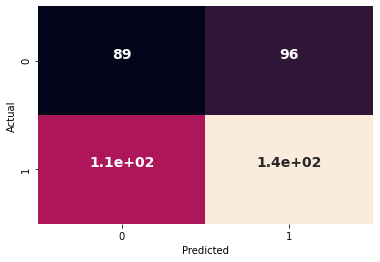

In [20]:
# Ploteo la matrix de confusión
import seaborn as sn
df_cm = pd.DataFrame(Matrix_OPT, index = [i for i in "01"],
                  columns = [i for i in "01"])

plt.figure(0.5)
heat_map = sn.heatmap(df_cm, xticklabels=True, yticklabels=True, annot=True, annot_kws = {"ha": 'center',"va": 'bottom'},cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')

for text in heat_map.texts:
    text.set_size(14)
    text.set_weight('bold')
    if text.get_text() == '5':
        text.set_color('black')

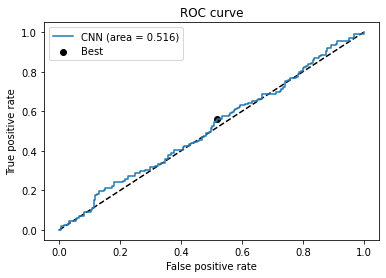

In [21]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='CNN (area = {:.3f})'.format(auc_keras))
plt.scatter(fpr_keras[ix], tpr_keras[ix], marker='o', color='black', label='Best')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

## **Validación**

In [23]:
y_pred_keras_tot = np.array([])
y_pred_rf_tot = np.array([])
y_test_total = np.array([])

xl_train, xl_test, yl_train, yl_test = train_test_split(local_data.iloc[:,4:], local_data.iloc[:,3], test_size=0.3, random_state=11)
xg_train, xg_test, yg_train, yg_test = train_test_split(global_data.iloc[:,4:], global_data.iloc[:,3], test_size=0.3, random_state=11)
xs_train, xs_test, ys_train, ys_test = train_test_split(stellar_params.iloc[:,4:], stellar_params.iloc[:,3], test_size=0.3, random_state=11)
   
# Definimos las dimensiones
n_outputs = 1
nL_timesteps, nL_features  = xl_train.shape[0], xl_train.shape[1]
nG_timesteps, nG_features  = xg_train.shape[0], xg_train.shape[1]
nS_timesteps, nS_features  = xs_train.shape[0], xs_train.shape[1]
      
# Expandimos las dimensiones
xle_train = np.expand_dims(xl_train,axis=-1) # axis=-3 para que se adapte a la forma del tensor
yle_train = np.array(yl_train) # Hay que trasponer 
xge_train = np.expand_dims(xg_train,axis=-1)
yge_train = np.array(yg_train)
xse_train = np.expand_dims(xs_train,axis=-1)
yse_train = np.array(ys_train)
    
# Multiple Inputs

# first input model
inputLocalView = Input(shape=(nL_features, 1))
inputLocalView.set_shape([nL_timesteps, nL_features, 1])

CL1 = Conv1D(filters=16, kernel_size=5, activation='relu')(inputLocalView)
CL2 = Conv1D(filters=16, kernel_size=5, activation='relu')(CL1)

ML1 = MaxPooling1D(pool_size=7, strides=2)(CL2)

CL3 = Conv1D(filters=32, kernel_size=5, activation='relu')(ML1)
CL4 = Conv1D(filters=32, kernel_size=5, activation='relu')(CL3)

ML2 = MaxPooling1D(pool_size=7, strides=2)(CL4)
flat1 = Flatten()(ML2)

# second input model

inputGlobalView = Input(shape=(nG_features, 1))
inputGlobalView.set_shape([nG_timesteps, nG_features, 1])

CG1 = Conv1D(filters=16, kernel_size=5, activation='relu')(inputGlobalView)
CG2 = Conv1D(filters=16, kernel_size=5, activation='relu')(CG1)

MG1 = MaxPooling1D(pool_size=3, strides=2)(CG2)

CG3 = Conv1D(filters=32, kernel_size=5, activation='relu')(MG1)
CG4 = Conv1D(filters=32, kernel_size=5, activation='relu')(CG3)

MG2 = MaxPooling1D(pool_size=2, strides=2)(CG4)

CG5 = Conv1D(filters=64, kernel_size=5, activation='relu')(MG2)
CG6 = Conv1D(filters=64, kernel_size=5, activation='relu')(CG5)

MG3 = MaxPooling1D(pool_size=2, strides=2)(CG6)

CG7 = Conv1D(filters=128, kernel_size=3, activation='relu')(MG3)
CG8 = Conv1D(filters=128, kernel_size=3, activation='relu')(CG7)

MG4 = MaxPooling1D(pool_size=2, strides=2)(CG8)

flat2 = Flatten()(MG4)

# third input model

StellarParam6PInput = Input(shape=(nS_features, 1))
StellarParam6PInput.set_shape([nS_timesteps, nS_features, 1])

# StellarParam6PInput=(nS_features,1)
flat3 = Flatten()(StellarParam6PInput)
# merge input models
merge = concatenate([flat1, flat2, flat3])

# interpretation model
hidden1 = Dense(256, activation='relu')(merge)
hidden2 = Dense(256, activation='relu')(hidden1)
hidden3 = Dense(256, activation='relu')(hidden2)
hidden4 = Dense(256, activation='relu')(hidden3)
#2output = Dense(n_outputs, activation='tanh')(hidden4)
output = Dense(n_outputs, activation='tanh')(hidden4)
model = Model(inputs=[inputLocalView, inputGlobalView,StellarParam6PInput], outputs=output)
#loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'ce']
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    #loss_weights=['main_output': 1., 'aux_output': 0.2]) por si queremos darles pesos diferentes

batch_size=1769

#Aumento número de muestras
for i in range(10):
    print(i)

    # Divido entre entrenamiento y test
    xl_train, xl_test, yl_train, yl_test = train_test_split(local_data.iloc[:,4:], local_data.iloc[:,3], test_size=0.2, random_state=11+i)
    xg_train, xg_test, yg_train, yg_test = train_test_split(global_data.iloc[:,4:], global_data.iloc[:,3], test_size=0.2, random_state=11+i)
    xs_train, xs_test, ys_train, ys_test = train_test_split(stellar_params.iloc[:,4:], stellar_params.iloc[:,3], test_size=0.2, random_state=11+i)
    
    # fit forma 2
    FIT = model.fit([xle_train, xge_train, xse_train], yle_train, epochs=50, batch_size=batch_size, verbose=0)
    
    xle_test = np.expand_dims(xl_test,axis=-1)
    yle_test = np.array(yl_test) 
    xge_test = np.expand_dims(xg_test,axis=-1)
    yge_test = np.array(yg_test)
    xse_test = np.expand_dims(xs_test,axis=-1)
    yse_test = np.array(ys_test)
    
    # Creo la RoC
    y_pred_kerasC = model.predict([xle_test,xge_test,xse_test]).ravel()

    #Lleno los vectores totales
    y_pred_keras_tot = np.concatenate((y_pred_keras_tot,y_pred_kerasC))
    
    y_test_total = np.concatenate((y_test_total, yle_test))

0
1
2
3
4
5
6
7
8
9


## **Obtención de métricas**

In [24]:
# Defino las métricas

fpr_kerasTotal, tpr_kerasTotal, thresholds_kerasTotal = roc_curve(y_test_total, y_pred_keras_tot)
auc_kerasTotal = auc(fpr_kerasTotal, tpr_kerasTotal)
gmeans = np.sqrt(tpr_kerasTotal * (1-fpr_kerasTotal))

# localiza el índice del mayor g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds_kerasTotal[ix], gmeans[ix]))

Best Threshold=0.102715, G-Mean=0.508


In [25]:
# Umbral estándar
labels_Standart = (y_pred_keras_tot >= 0.5).astype(np.int)
PhiCoeff_Standart = matthews_corrcoef(y_test_total, labels_Standart)
Matrix_Standart = confusion_matrix(y_test_total, labels_Standart)
F_Measure_Standart = f1_score(y_test_total, labels_Standart, average='binary')

# Mostramos las métricas
auc_kerasTotal, PhiM_Standart,F_Measure_Standart, print(Matrix_Standart)

[[1816    0]
 [2610    4]]


(0.5093930428832886, 0.0, 0.0030557677616501145, None)

In [26]:
# Umbral OPT
labels_OPT =(y_pred_keras_tot >= thresholds_kerasTotal[ix]).astype(np.int)
PhiCoeff_OPT = matthews_corrcoef(y_test_total, labels_OPT)
Matrix_OPT = confusion_matrix(y_test_total, labels_OPT)
F_Measure_OPT = f1_score(y_test_total, labels_OPT, average='binary')
Accuracy_OPT= accuracy_score(y_test_total, labels_OPT, normalize=True)
Recall_OPT= recall_score(y_test_total, labels_OPT, average=None)
Average_precision_OPT= average_precision_score(y_test_total, labels_OPT)

In [27]:
# Imprimo por pantalla las métricas
print("AUC:", auc_kerasTotal)
print("F_Measure:", F_Measure_OPT)
print("PhiCoeff:", PhiCoeff_OPT)
print("Average_precision:", Average_precision_OPT)
print("Accuracy:", Accuracy_OPT)
print("Recall:", Recall_OPT)
print("Matriz de confusión:")
print( Matrix_OPT)

AUC: 0.5093930428832886
F_Measure: 0.5859772816294554
PhiCoeff: 0.023640361563995505
Average_precision: 0.5959357183943297
Accuracy: 0.5227990970654628
Recall: [0.45154185 0.57230298]
Matriz de confusión:
[[ 820  996]
 [1118 1496]]


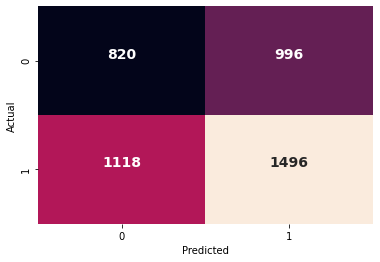

In [28]:
# Ploteo la matrix de confusión

df_cm_OPT = pd.DataFrame(Matrix_OPT, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(0.5)
heat_map = sn.heatmap(df_cm_OPT, xticklabels=True, yticklabels=True, annot=True, fmt='g', annot_kws = {"ha": 'center',"va": 'bottom'},cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')

for text in heat_map.texts:
    text.set_size(14)
    text.set_weight('bold')
    if text.get_text() == '33':
        text.set_color('black')

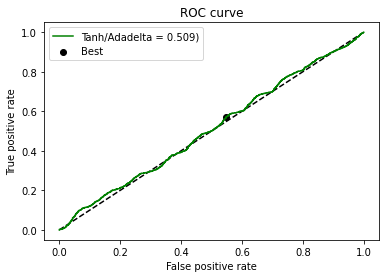

In [29]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_kerasTotal, tpr_kerasTotal,  color='green', label='Tanh/Adadelta = {:.3f})'.format(auc_kerasTotal))
plt.scatter(fpr_kerasTotal[ix], tpr_kerasTotal[ix], marker='o', color='black', label='Best')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()